Created from https://github.com/samoylv/WPG/blob/develop/samples/sos_2016/example02_beamline_mirror.ipynb by Juncheng E

## Propagation through a beamline with mirror 

### Import modules

In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


#Importing necessary modules:
import os
import sys
import copy
import time
import errno
import numpy as np
import pylab as plt

from IPython.display import Image

#change the path to root folder of the WPG installation
#wpg_path = '/Users/lsamoylv/code/ghub/srw_update/'
# wpg_path = os.path.join('..','WPG')

wpg_path = '/gpfs/exfel/data/user/juncheng/WPG/'
sys.path.insert(0,wpg_path)

#Import base wavefront class
from wpg import Wavefront

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront

#import srwl 
from wpg.srwlib import srwl

#import some helpers functions
from wpg.wpg_uti_exfl import calculate_theta_fwhm_cdr_s1
from wpg.wpg_uti_wf import calc_pulse_energy, averaged_intensity, calculate_fwhm, get_intensity_on_axis
from wpg.wpg_uti_wf import plot_wf, look_at_q_space

plt.ion()

### define helper functions

In [3]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [4]:
# For SimEx output

def calculate_fwhm(wfr):
    """
    Calculate FWHM of the beam calculating number of point bigger then max/2 throuhgt center of the image

    :param wfr:  wavefront
    :return: {'fwhm_x':fwhm_x, 'fwhm_y': fwhm_y} in [m]
    """
    intens = wfr.get_intensity(polarization='total').sum(axis=-1);


    mesh = wfr.params.Mesh
    dx = (mesh.xMax-mesh.xMin)/mesh.nx
    dy = (mesh.yMax-mesh.yMin)/mesh.ny

    x_center = intens[intens.shape[0]//2,:]
    fwhm_x = len(x_center[x_center>x_center.max()/2])*dx

    y_center = intens[:,intens.shape[1]//2]
    fwhm_y = len(y_center[y_center>y_center.max()/2])*dy
    return {'fwhm_x':fwhm_x, 'fwhm_y': fwhm_y}

def add_custom_data(wf, bl0):
    """ Utility to store additional info on the wavefront . """

    # Add more metadata.
    fwhm = calculate_fwhm(wf)


    wf.custom_fields['/misc/xFWHM'] = fwhm['fwhm_x']
    wf.custom_fields['/misc/yFWHM'] = fwhm['fwhm_y']
    wf.custom_fields['/params/beamline/printout'] = str(bl0)

    wf.custom_fields['/info/contact'] = [
        'Name: Liubov Samoylova', 'Email: liubov.samoylova@xfel.eu',
        'Name: Alexey Buzmakov', 'Email: buzmakov@gmail.com']
    wf.custom_fields['/info/data_description'] = 'This dataset contains infromation about wavefront propagated through beamline (WPG and SRW frameworks).'
    wf.custom_fields['/info/method_description'] = """WPG, WaveProperGator (http://github.com/samoylv/WPG)is an interactive simulation framework for coherent X-ray wavefront propagation.\nSRW, Synchrotron Radiation Workshop (http://github.com/ochubar/SRW),  is a physical optics computer code  for simulation of the radiation wavefront propagation through optical systems of beamlines as well as  detailed characteristics of Synchrotron Radiation (SR) generated by relativistic electrons in magnetic fields of arbitrary configuration."""
    wf.custom_fields['/info/package_version'] = '2014.1'

## define a beamline with offset mirror

In [5]:
%%file beamline02_mirror.py


def get_beamline():
    import os
    import wpg
    from wpg import Beamline
    from wpg.optical_elements import Aperture, Drift, CRL, Empty, Use_PP, Mirror_plane,Mirror_plane_2d 
    from wpg.wpg_uti_oe import show_transmission

    wpg_path = os.path.abspath(os.path.dirname(wpg.__file__))
    data_path = 'data_example_02'

    # S1 beamline layout
    # Geometry ###
    src_to_hom1 = 257.8  # Distance source to HOM 1 [m]
    src_to_hom2 = 267.8  # Distance source to HOM 2 [m]
    src_to_imager = 887.8 # distance source to imager 

    theta_om = 3.6e-3  # [rad]

    om_mirror_length = 0.8  # [m]
    om_clear_ap = om_mirror_length * theta_om

    # define the beamline:
    bl0 = Beamline()

    # Define HOM1.
    aperture_x_to_y_ratio = 1
    hom1 = Aperture(
        shape='r', ap_or_ob='a', Dx=om_clear_ap, Dy=om_clear_ap / aperture_x_to_y_ratio)
    bl0.append(
        hom1, Use_PP(semi_analytical_treatment=0))

    # Define mirror profile
    # Apply distortions.
    mirrors_path = '../wpg-samples/data_common'
    # Define mirror profile
    hom1_wavefront_distortion = Mirror_plane(orient='x', 
                                             theta=theta_om, 
                                             length=om_mirror_length, 
                                             range_xy=om_clear_ap/aperture_x_to_y_ratio, 
                                             filename=os.path.join(
                                             mirrors_path, 'mj37_2.dat'), 
                                             scale=1.,
                                             bPlot=True)
    print('HOM1 WF distortion'); show_transmission(hom1_wavefront_distortion);

    zoom = 1.2

    bl0.append(hom1_wavefront_distortion,
               Use_PP(semi_analytical_treatment=0, zoom=zoom, sampling=zoom/0.8))

    # Free space propagation from hom1 to hom2
    hom1_to_hom2_drift = Drift(src_to_hom2 - src_to_hom1)
    bl0.append(hom1_to_hom2_drift, Use_PP(semi_analytical_treatment=0))

    # Define HOM2 as aperture.
    zoom = 1.0
    hom2 = Aperture('r', 'a', om_clear_ap, om_clear_ap / aperture_x_to_y_ratio)
    bl0.append(hom2, Use_PP(semi_analytical_treatment=0,
                            zoom=zoom, sampling=zoom / 0.75))

    # drift to imager
    hom2_to_imager = Drift(src_to_imager - src_to_hom2)

    bl0.append(hom2_to_imager, Use_PP(semi_analytical_treatment=1))

    return bl0

Overwriting beamline02_mirror.py


In [6]:
%%file only_hom1.py

def get_beamline():
    import os
    import wpg
    from wpg import Beamline
    from wpg.optical_elements import Aperture, Drift, CRL, Empty, Use_PP, Mirror_plane,Mirror_plane_2d 
    from wpg.wpg_uti_oe import show_transmission

    wpg_path = os.path.abspath(os.path.dirname(wpg.__file__))
    data_path = 'data_example_02'

    # S1 beamline layout
    # Geometry ###
    src_to_hom1 = 257.8  # Distance source to HOM 1 [m]
    src_to_hom2 = 267.8  # Distance source to HOM 2 [m]
    src_to_imager = 887.8 # distance source to imager 

    theta_om = 3.6e-3  # [rad]

    om_mirror_length = 0.8  # [m]
    om_clear_ap = om_mirror_length * theta_om

    # define the beamline:
    bl0 = Beamline()

    # Define HOM1.
    aperture_x_to_y_ratio = 1
    hom1 = Aperture(
        shape='r', ap_or_ob='a', Dx=om_clear_ap, Dy=om_clear_ap / aperture_x_to_y_ratio)
    bl0.append(
        hom1, Use_PP(semi_analytical_treatment=0))
    
    return bl0

Overwriting only_hom1.py


## Define source 
### Gaussian beam

In [7]:
out_prefix = 'gb_'
src_oe1 = 257.8 # Distance to the first OE [m]

# Central photon energy.
ekev = 8.5 # Energy [keV]

# Pulse parameters.
qnC = 0.1               # e-bunch charge, [nC]
pulse_duration = 9.e-15 # [s] <-is not used really, only ~coh time pulse duration has physical meaning 
pulseEnergy = 1.5e-3    # total pulse energy, J
coh_time = 0.8e-15      # [s]<-should be SASE coherence time, then spectrum will be the same as for SASE 
                        # check coherence time for 8 keV 0.5 nC SASE1

# Angular distribution
theta_fwhm = calculate_theta_fwhm_cdr_s1(ekev,qnC) # CDR2011 empirical formula
#theta_fwhm = 3.2e-6 #empiric value for nzc 15 (linear SASE before saturation)
print('divergence FWHM {0:.1f} urad'.format(theta_fwhm*1e6))

divergence FWHM 2.5 urad


In [8]:
# Gaussian beam parameters
wlambda = 12.4*1e-10/ekev        # wavelength 
w0 = wlambda/(np.pi*theta_fwhm)  # FWHM beam waist; 
w0_a = w0/(2*np.sqrt(np.log(2))) # sigma of amplitude
zR = (np.pi*w0_a**2)/wlambda     # Rayleigh length, max WF curvature

# expected beam radius at OE1 position to get the range of the wavefront 
print('Intensity waist size: {:.0f} um FWHM'.format(w0*1e6))
print('Rayleigh length: {:.1f} m'.format(zR))
print('expected FWHM at distance {:.1f} m: {:.2f} mm'.format(src_oe1,theta_fwhm*src_oe1*1e3))

fname = '{0:s}at_{1:.0f}_m'.format(out_prefix,src_oe1);
bname = fname

Intensity waist size: 19 um FWHM
Rayleigh length: 2.8 m
expected FWHM at distance 257.8 m: 0.63 mm


In [9]:
bSaved=True
data_path = 'data_example_02';mkdir_p(data_path)
sig_num = 5.5
num_points = 400 #number of points
range_xy = w0_a * np.sqrt(1+(src_oe1/zR)**2)/np.sqrt(2)*sig_num;
print('range_xy at OE1: {:.1f} mm'.format(range_xy*1e3))
dx = 10.e-6; range_xy = dx*(num_points-1);
print('range_xy at OE1: {:.1f} mm'.format(range_xy*1e3))
nslices = 20; 

range_xy at OE1: 4.1 mm
range_xy at OE1: 4.0 mm


### create Gaussian beam

In [10]:
srwl_wf = build_gauss_wavefront(num_points, num_points, nslices, ekev, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,coh_time/np.sqrt(2), 
                                w0_a, w0_a, src_oe1,
                                pulseEn=pulseEnergy, pulseRange=8.)
wf = Wavefront(srwl_wf)
z0 = src_oe1
#defining name HDF5 file for storing wavefront
#store wavefront to HDF5 file 
if bSaved:     
    wf.store_hdf5(os.path.join(data_path,fname+'.h5')); 
    print('saving WF to {:s}'.format(os.path.join(data_path,fname+'.h5')))

xx=calculate_fwhm(wf);
print('FWHM at distance {:.1f} m: {:.2f} x {:.2f} mm2'.format(z0,xx[u'fwhm_x']*1e3,xx[u'fwhm_y']*1e3));

saving WF to data_example_02/gb_at_258_m.h5
FWHM at distance 257.8 m: 0.62 x 0.62 mm2


### show Gaussian wavefront in R- and Q-space

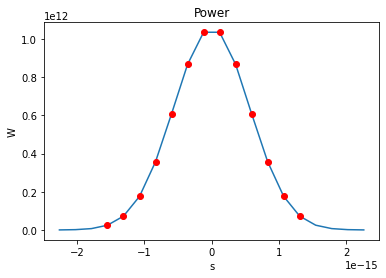

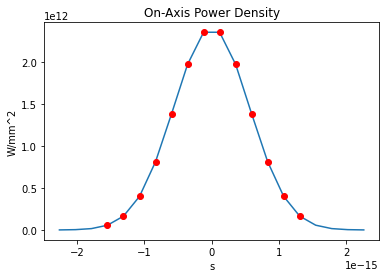

number of meaningful slices: 13
Pulse energy 0.0015 J
R-space
(400,) (400,)
FWHM in x = 6.185e-04 m.
FWHM in y = 6.185e-04 m.


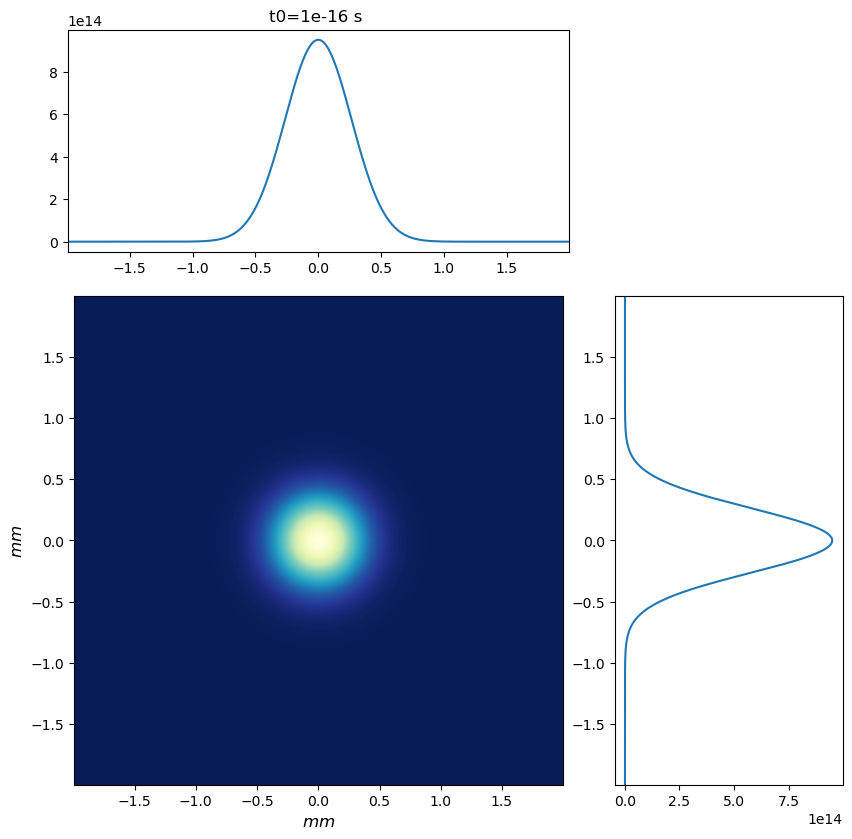

Q-space
{'fwhm_x': 2.4370274558823524e-06, 'fwhm_y': 2.4370274558823524e-06}
Q-space
(400,) (400,)


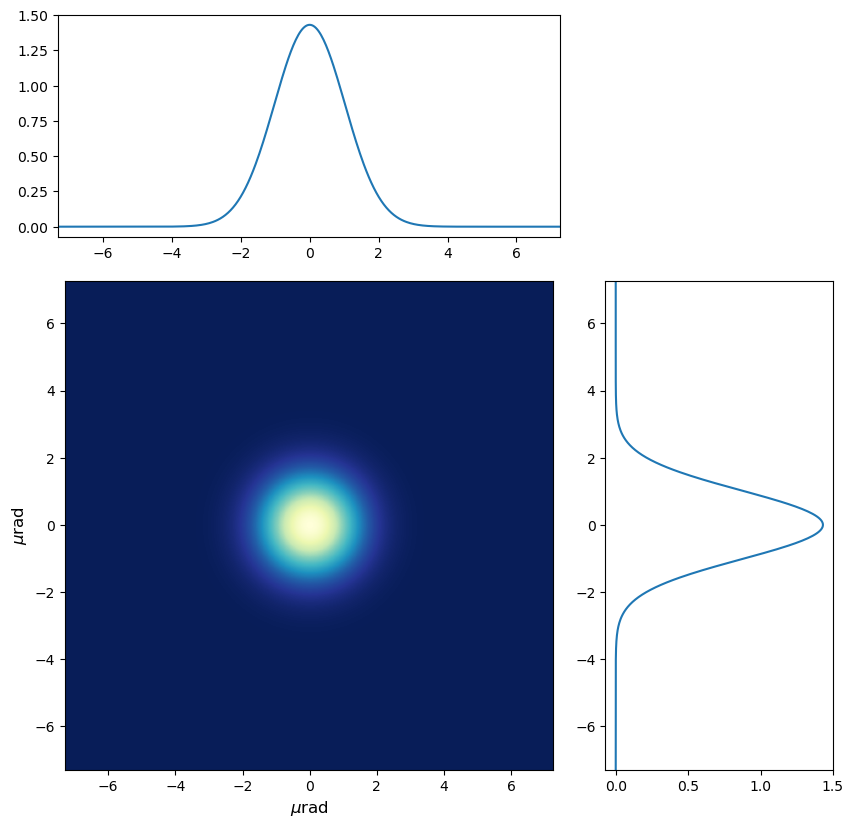

In [11]:
plot_wf(wf)
look_at_q_space(wf)

## Propogate through an aperture

In [12]:
#loading beamline from file
import imp
# custom_beamline = imp.load_source('custom_beamline', 'beamline02_mirror.py')
custom_beamline = imp.load_source('custom_beamline', 'only_hom1.py')
get_beamline = custom_beamline.get_beamline
bl = get_beamline()
print(bl)

print('loading wavefront from {:s}...'.format(os.path.join(data_path,fname+'.h5')));t0 = time.time();
wf=Wavefront() ;wf.load_hdf5(os.path.join(data_path,fname+'.h5'))
print('done in {:.2f} s'.format(time.time()-t0))
srwl.SetRepresElecField(wf._srwl_wf, 'f') # <---- switch to frequency domain
print('propagating through beamline...');t0 = time.time();
bl.propagate(wf)
print('done in {:.2f} s'.format(time.time()-t0))

out_file_name = 'Gaussian_3D.h5'
add_custom_data(wf,bl)
wf.store_hdf5(out_file_name)
print('save hdf5:'+ out_file_name)

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.00288
	Dy = 0.00288
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	

loading wavefront from data_example_02/gb_at_258_m.h5...
done in 0.23 s
propagating through beamline...
done in 0.04 s
save hdf5:Gaussian_3D.h5


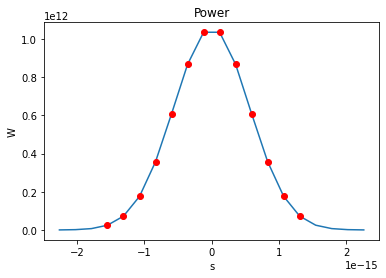

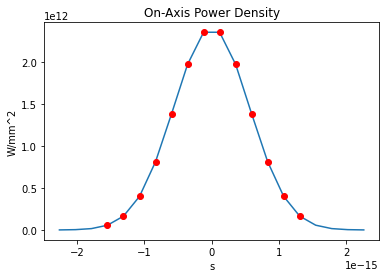

number of meaningful slices: 13
Pulse energy 0.0015 J
R-space
(400,) (400,)
FWHM in x = 6.185e-04 m.
FWHM in y = 6.185e-04 m.


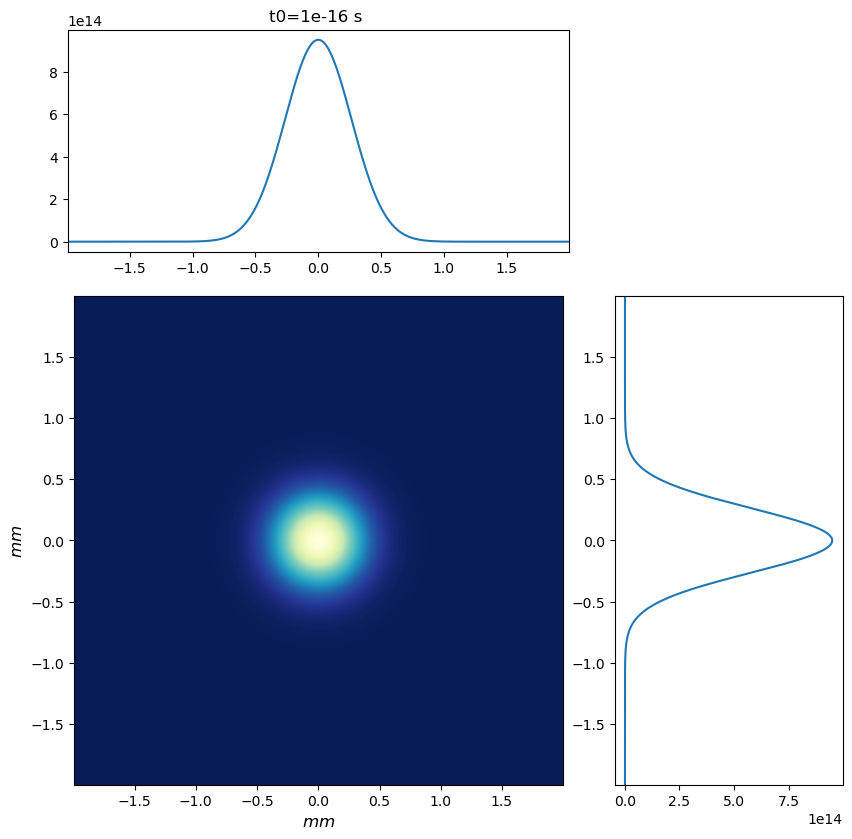

Q-space
{'fwhm_x': 2.4370274558823524e-06, 'fwhm_y': 2.4370274558823524e-06}
Q-space
(400,) (400,)


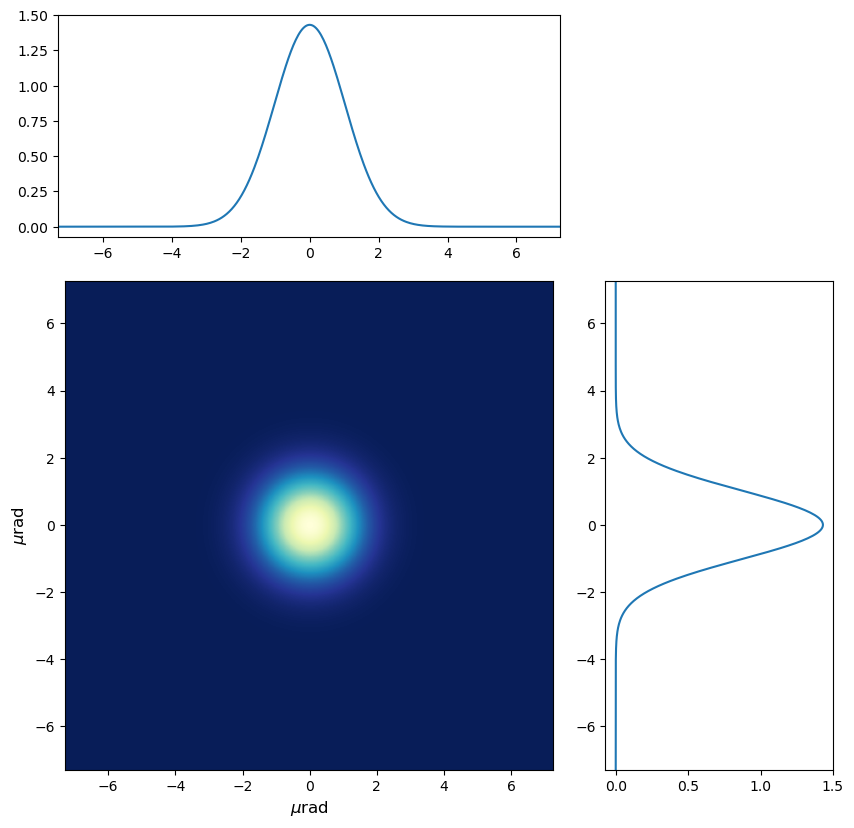

In [13]:
srwl.SetRepresElecField(wf._srwl_wf, 't')
plot_wf(wf)
look_at_q_space(wf)